<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/DiffusionKernel_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Kernel x Communicability

This notebook implements the diffusion kernel (DF; Kondor & Lafferty, 2002), also known as communicability. Building on Garvert et al. (2017), I construct a graph Laplacian from the learned adjacency structure (A) and compute the diffusion kernel via matrix exponentiation. The resulting kernel (K) quantifies similarity between objects (nodes) based on all possible paths in the graph, weighted by their length.

This model provides an alternative to the successor representation (SR) for capturing latent structure in neural data. The kernel can be converted to dissimilarity matrices (DSMs) and compared to neural DSMs to evaluate its fit.

# Step 1: Build the Adjacency Matrix

In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])

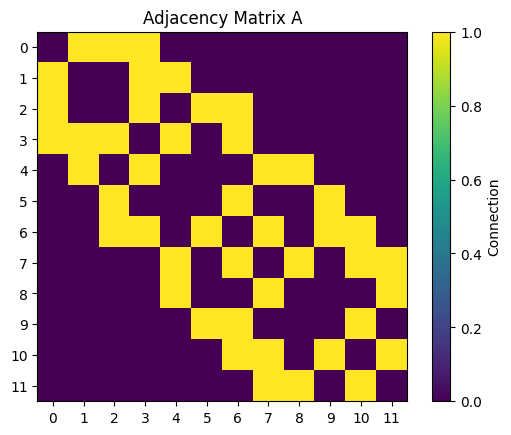

In [53]:
# Visualize adjacency matrix
plt.imshow(A, cmap='viridis')
plt.colorbar(label='Connection')
plt.title("Adjacency Matrix A")

# Force every tick to be shown
num_nodes = A.shape[0]
plt.xticks(ticks=np.arange(num_nodes))  # 0 to 11
plt.yticks(ticks=np.arange(num_nodes))  # 0 to 11

plt.show()

# Step 2: Build the Degree Matrix

The degree matrix D is a diagonal matrix that contains the number of connections (degree) for each node. (I am not sure whether this is true but I think I also get the degrees for each node by looking at each column (I think this is the same as each row here but more intuitive) and then just counting, e.g., how many other nodes are connected to e.g., node 0. In this case it is 3 etc.)
We compute the degree of each node by summing across its row in the adjacency matrix A. This matrix will
be used to compute the graph Laplacian in the next step: `L = D - A`.

In [54]:
# Step 2: Define the degree matrix D (diagonal with the number of connections per node)

# Automatically compute node degrees from A
degrees = np.sum(A, axis=1)

# Create the degree matrix D (same shape as A, with degrees on the diagonal)
D = np.diag(degrees)

In [55]:
# Print degree vector and matrix #I think this makes it very clear, especially when comparing to the adjacency matrix (A)
print("Degrees per node:", degrees)
print("Degree matrix D:\n", D)

Degrees per node: [3 3 4 5 4 3 6 5 3 3 4 3]
Degree matrix D:
 [[3 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 3]]


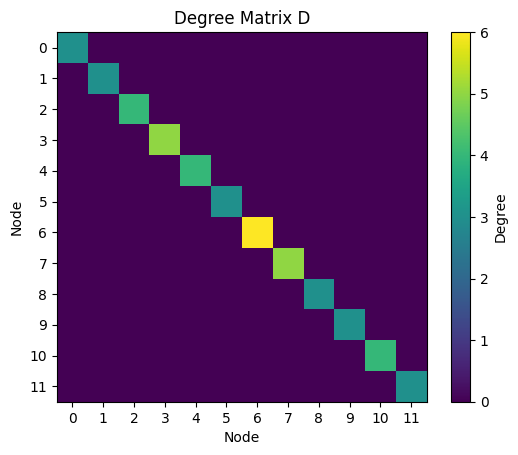

In [56]:
# Visualize D as a heatmap (only diagonal entries are nonzero)
plt.imshow(D, cmap='viridis')
plt.colorbar(label='Degree')
plt.title('Degree Matrix D')
plt.xticks(np.arange(12))
plt.yticks(np.arange(12))
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

# Step 3: Graph Laplacian L = D - A

The graph Laplacian L is computed as the difference between the degree matrix D and the adjacency matrix A.
It quantifies how each node differs from its neighbours and is central to the diffusion kernel model. The
Laplacian will be used in the next step to compute the diffusion kernel via matrix exponentiation.

In [57]:
# Step 3: Compute the graph Laplacian
L = D - A

# Print Laplacian matrix (optional)
print("Graph Laplacian L:\n", L)

Graph Laplacian L:
 [[ 3 -1 -1 -1  0  0  0  0  0  0  0  0]
 [-1  3  0 -1 -1  0  0  0  0  0  0  0]
 [-1  0  4 -1  0 -1 -1  0  0  0  0  0]
 [-1 -1 -1  5 -1  0 -1  0  0  0  0  0]
 [ 0 -1  0 -1  4  0  0 -1 -1  0  0  0]
 [ 0  0 -1  0  0  3 -1  0  0 -1  0  0]
 [ 0  0 -1 -1  0 -1  6 -1  0 -1 -1  0]
 [ 0  0  0  0 -1  0 -1  5 -1  0 -1 -1]
 [ 0  0  0  0 -1  0  0 -1  3  0  0 -1]
 [ 0  0  0  0  0 -1 -1  0  0  3 -1  0]
 [ 0  0  0  0  0  0 -1 -1  0 -1  4 -1]
 [ 0  0  0  0  0  0  0 -1 -1  0 -1  3]]


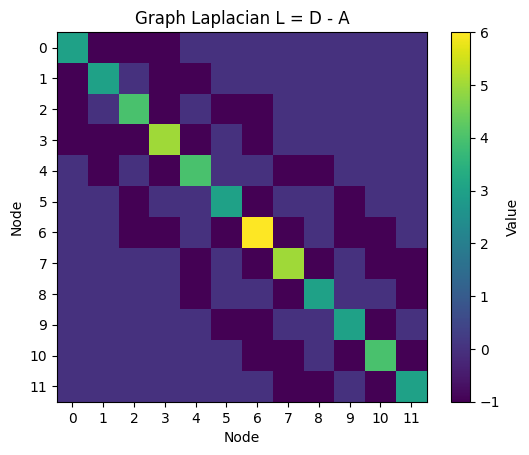

In [58]:
# Visualize Laplacian matrix
plt.imshow(L, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Graph Laplacian L = D - A')
plt.xticks(np.arange(12))
plt.yticks(np.arange(12))
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

# Step 4: Diffusion Kernel (Communicability)

The diffusion kernel K captures similarity between nodes by simulating how information would diffuse through
the graph structure.

It is computed as the matrix exponential of the negative scaled graph Laplacian:
K = exp(-αL), where α is the diffusion rate.

*   Higher α results in more global similarity
*   Lower α emphasizes local connectivity

This kernel serves as our model-based similarity structure for comparison with neural data.

In [59]:
from scipy.linalg import expm

In [60]:
# Step 4: Compute the diffusion kernel (communicability)

alpha = 0.0  # I can change these to other values e.g., 0.1 or 5.0
K = expm(-alpha * L)

In [61]:
# Print or inspect the kernel matrix
print(f"Diffusion kernel (α = {alpha}):\n", K)

Diffusion kernel (α = 0.0):
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


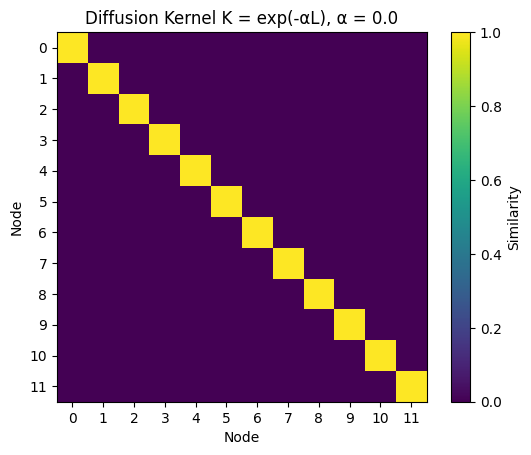

In [62]:
# Visualize the diffusion kernel as a heatmap
plt.imshow(K, cmap='viridis')
plt.colorbar(label='Similarity')
plt.title(f'Diffusion Kernel K = exp(-αL), α = {alpha}')
plt.xticks(np.arange(12))
plt.yticks(np.arange(12))
plt.xlabel('Node')
plt.ylabel('Node')
plt.show()

# (Intermediate Step: Choosing boundaries for α)

To better understand how the diffusion kernel behaves as α increases, I visualise the similarity matrices K
for selected values of α. This helps identify the range in which α produces meaningful variation in graph
structure. For very small α, only direct neighbours are similar. As α increases, similarity spreads to more
distant nodes. At high α values, the kernel saturates and becomes less informative.

This step is especially important for later comparison to γ in the successor representation (SR). I want to choose
a range of α values that captures a similar dynamic range of structure and avoids saturation or underfitting.

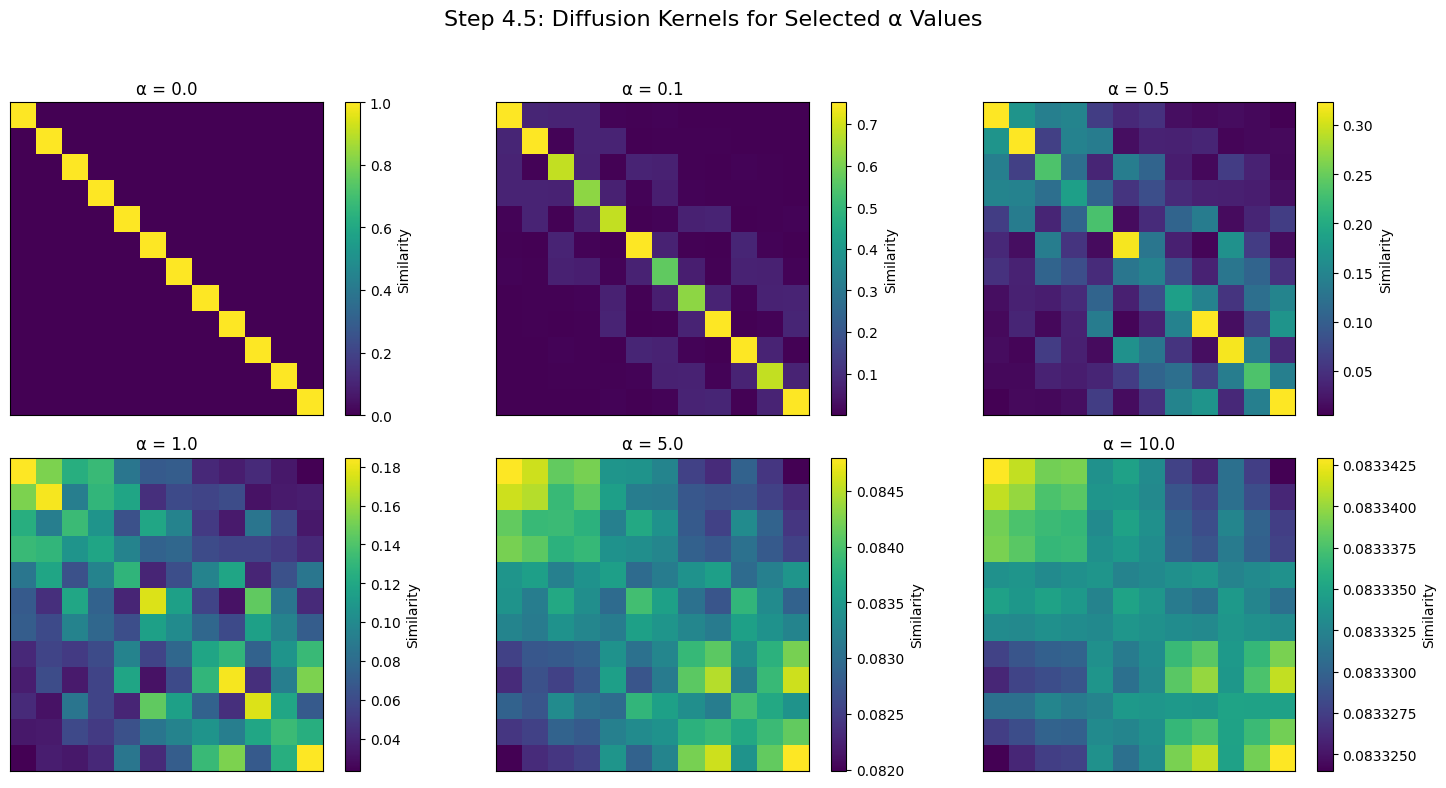

In [63]:
# Compute kernels for selected alphas
selected_alphas = [0.0, 0.1, 0.5, 1.0, 5.0, 10.0]
selected_kernels = [expm(-alpha * L) for alpha in selected_alphas]

# Plot side-by-side comparison of selected diffusion kernels
plt.figure(figsize=(15, 8))
for i, (alpha, K) in enumerate(zip(selected_alphas, selected_kernels)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K, cmap='viridis')
    plt.title(f"α = {alpha}")
    plt.colorbar(label='Similarity')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Step 4.5: Diffusion Kernels for Selected α Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


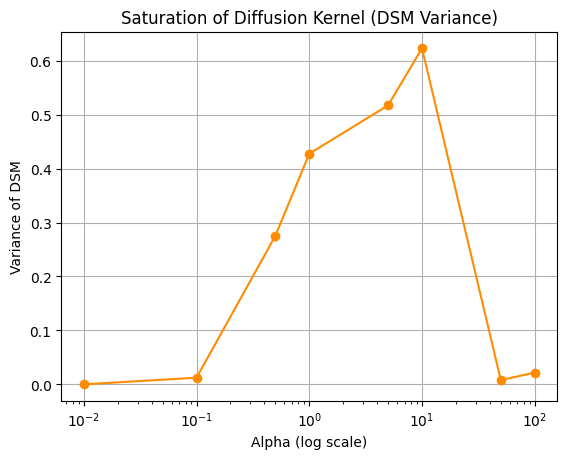

In [65]:
# The following code was generated with ChatGPT

from scipy.spatial.distance import pdist, squareform

# Define a set of alpha values to explore variance (same as before)
alpha_vals = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
dsms = []
variances = []

for alpha in alpha_vals:
    K = expm(-alpha * L)
    corr_matrix = np.corrcoef(K)
    dsm = 1 - corr_matrix
    dsms.append(dsm)

    # Compute variance of upper triangle (excluding diagonal)
    upper_triangle = dsm[np.triu_indices_from(dsm, k=1)]
    variances.append(np.var(upper_triangle))

# Plot DSM variance vs alpha
plt.figure()
plt.plot(alpha_vals, variances, marker='o', color='darkorange')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Variance of DSM")
plt.title("Saturation of Diffusion Kernel (DSM Variance)")
plt.grid(True)
plt.show()

This plot shows how the variance of the diffusion kernel DSM changes as a function of α. At very low α values (e.g., 0.01–0.1), the DSM exhibits almost no variance, reflecting that similarity remains highly localized and structure is minimal. As α increases, the DSM variance rises, reaching a peak around α = 10, where the kernel captures the richest structural differences between nodes. Beyond this point, the variance drops sharply, indicating saturation: the similarity matrix becomes increasingly uniform, and meaningful distinctions between nodes are lost. This curve helps define a principled α range for later model fitting, ensuring that α and γ (from the SR model) are compared on equal footing in terms of structural expressiveness.


# Step 5: Loop over α values and compute model DSMs

Here, I generate 100 diffusion kernels using α values from 0.01 to 10 (log-spaced) to match the γ from the SR notebook, which were bounded between 0.0 and 1.0 and for which I computed 100 values.

Now, for each kernel matrix K,
I compute a model dissimilarity matrix (DSM) by taking 1 − Pearson correlation between rows. These DSMs can
then be compared to neural DSMs to find the best-fitting α for each ROI and subject.

In [66]:
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm  # for progress bar

In [69]:
# Step 5: Generate model DSMs for a range of alpha values

# Choose alpha range (based on saturation analysis)
alpha_values = np.logspace(-2, 1, 100)  # from 0.01 to 10.0 (log-spaced)
model_dsms = []  # list to store each model DSM
kernel_matrices = []  # optional: store K for each alpha

for alpha in tqdm(alpha_values):
    # 1. Compute diffusion kernel
    K = expm(-alpha * L)
    kernel_matrices.append(K)

    # 2. Convert to DSM: 1 - Pearson correlation between rows
    similarity_matrix = np.corrcoef(K)
    dsm = 1 - similarity_matrix
    model_dsms.append(dsm)

100%|██████████| 100/100 [00:00<00:00, 4502.50it/s]


In [70]:
# Sanity check: since the progress bar went really fast I wanted to check it computed all 100 DSMs

print(f"Number of DSMs: {len(model_dsms)}")
print(f"Shape of one DSM: {model_dsms[0].shape}")

Number of DSMs: 100
Shape of one DSM: (12, 12)


Visualizing a few DSMs

In [71]:
import matplotlib.pyplot as plt

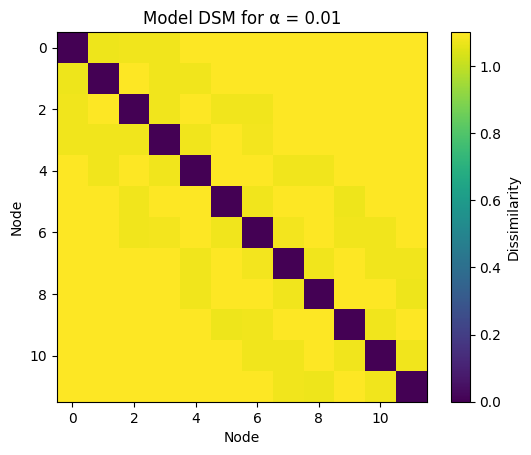

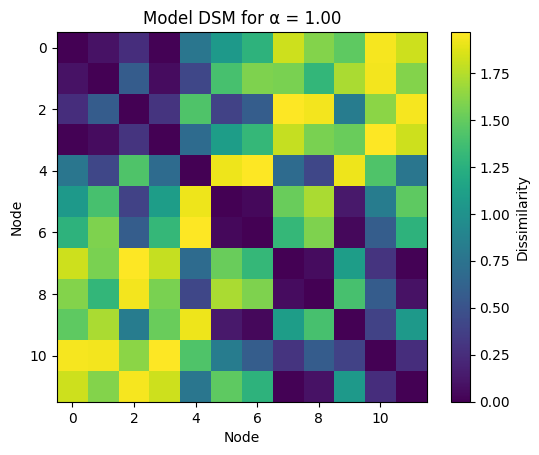

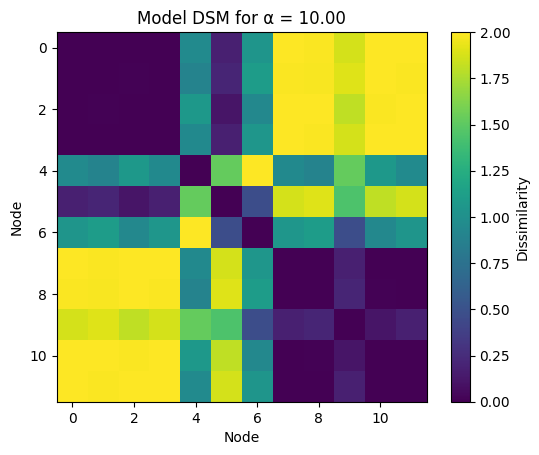

In [78]:
# Pick 3 α values to visualize

for idx in [0, 66, 99]:  # roughly α = 0.01, ~1.0, and 10.0
    plt.figure()
    plt.imshow(model_dsms[idx], cmap='viridis')
    plt.colorbar(label='Dissimilarity')
    plt.title(f'Model DSM for α = {alpha_values[idx]:.2f}')
    plt.xlabel("Node")
    plt.ylabel("Node")
    plt.show()

In [79]:
print("Sample DSM (middle α):\n", model_dsms[49][:5, :5])

Sample DSM (middle α):
 [[2.22044605e-16 5.47827462e-01 6.12450027e-01 4.62189213e-01
  1.08100414e+00]
 [5.47827462e-01 0.00000000e+00 1.05335239e+00 4.83671217e-01
  6.35743093e-01]
 [6.12450027e-01 1.05335239e+00 0.00000000e+00 6.12704047e-01
  1.33672793e+00]
 [4.62189213e-01 4.83671217e-01 6.12704047e-01 0.00000000e+00
  7.61869630e-01]
 [1.08100414e+00 6.35743093e-01 1.33672793e+00 7.61869630e-01
  0.00000000e+00]]
